In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

# Code for data extraction
1. In this section we will load the raw data and extract utilization and frequency value

In [80]:
utilData = pd.read_csv('./Util_Run1.csv')
utilData.shape

(2674, 6)

In [81]:
utilData.head()

,memUse,memTot,memfreq,cpuid,cpuload,cpufreq
0,604872,4612865,165000000,0,31,600000
1,675,28712,275000000,0,4,200000
2,1191888,12624777,413000000,0,8,200000
3,773492,8196989,275000000,0,9,300000
4,1144,57890,206000000,0,7,300000


In [82]:
utilData['memLoad'] = utilData['memUse']/utilData['memTot']

In [83]:
utilData['cpuScore'] = utilData['cpuload']*utilData['cpufreq']/1400000
utilData['cpuF'] = utilData['cpufreq']/1000000

In [84]:
utilData.head()

,memUse,memTot,memfreq,cpuid,cpuload,cpufreq,memLoad,cpuScore,cpuF
0,604872,4612865,165000000,0,31,600000,0.131127,13.285714,0.6
1,675,28712,275000000,0,4,200000,0.023509,0.571429,0.2
2,1191888,12624777,413000000,0,8,200000,0.094409,1.142857,0.2
3,773492,8196989,275000000,0,9,300000,0.094363,1.928571,0.3
4,1144,57890,206000000,0,7,300000,0.019762,1.500000,0.3


In [85]:
tot_train = utilData.iloc[0:2136]


In [86]:
train_1 = utilData.iloc[0:534]
train_2 = utilData.iloc[534:1068]
train_3 = utilData.iloc[1068:1602]
train_4 = utilData.iloc[1602:2136]
test_data = utilData.iloc[2136:]
print(train_1.tail())
test_data.shape

      memUse   memTot    memfreq  cpuid  cpuload  cpufreq   memLoad  \
529    41341   464426  825000000      0       50   800000  0.089015   
530    41341   464426  825000000      0       33   600000  0.089015   
531    41341   464426  825000000      0       30   600000  0.089015   
532    41341   464426  825000000      0       29   500000  0.089015   
533  2457799  3939455  825000000      0       40   700000  0.623893   

      cpuScore  cpuF  
529  28.571429   0.8  
530  14.142857   0.6  
531  12.857143   0.6  
532  10.357143   0.5  
533  20.000000   0.7  


(538, 9)

# Modeling 
In this section we will model the data and test its accuracy

In [166]:
model = ARIMA(tot_train['cpuScore'], order=(4,0,1), exog=tot_train['cpuF'])
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:               cpuScore   No. Observations:                 2136
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -6618.146
Date:                Fri, 02 Jun 2023   AIC                          13252.292
Time:                        15:19:30   BIC                          13297.625
Sample:                             0   HQIC                         13268.882
                               - 2136                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.5642      0.965    -20.265      0.000     -21.456     -17.672
cpuF          71.0723      0.327    217.139      0.000      70.431      71.714
ar.L1          0.3820      0.645      0.592      0.5

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [106]:
model1 = ARIMA(train_1['cpuF'], order=(4,0,1), exog=train_1['cpuScore'])
result1 = model1.fit()
print(result1.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  534
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 781.146
Date:                Fri, 02 Jun 2023   AIC                          -1546.291
Time:                        12:43:36   BIC                          -1512.048
Sample:                             0   HQIC                         -1532.892
                                - 534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2969      0.009     34.200      0.000       0.280       0.314
cpuScore       0.0127      0.000     66.935      0.000       0.012       0.013
ar.L1          0.2057      0.621      0.331      0.7

In [89]:
model2 = ARIMA(train_2['cpuF'], order=(4,0,1), exog=train_2['cpuScore'])
result2 = model2.fit()
print(result2.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  534
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 860.151
Date:                Fri, 02 Jun 2023   AIC                          -1704.303
Time:                        12:39:07   BIC                          -1670.059
Sample:                             0   HQIC                         -1690.904
                                - 534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5025      0.004    116.898      0.000       0.494       0.511
cpuScore       0.0093      0.000     88.776      0.000       0.009       0.010
ar.L1          0.1101      0.775      0.142      0.8

In [90]:
model3 = ARIMA(train_3['cpuF'], order=(4,0,1), exog=train_3['cpuScore'])
result3 = model3.fit()
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  534
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 665.241
Date:                Fri, 02 Jun 2023   AIC                          -1314.481
Time:                        12:39:08   BIC                          -1280.238
Sample:                             0   HQIC                         -1301.082
                                - 534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3416      0.014     24.330      0.000       0.314       0.369
cpuScore       0.0110      0.000     44.034      0.000       0.011       0.012
ar.L1          0.5962      0.224      2.656      0.0

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [91]:
model4 = ARIMA(train_4['cpuF'], order=(4,0,1), exog=train_4['cpuScore'])
result4 = model4.fit()
print(result4.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  534
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 644.420
Date:                Fri, 02 Jun 2023   AIC                          -1272.840
Time:                        12:39:09   BIC                          -1238.597
Sample:                             0   HQIC                         -1259.441
                                - 534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3036      0.008     37.465      0.000       0.288       0.320
cpuScore       0.0114      0.000     50.251      0.000       0.011       0.012
ar.L1          0.1254      0.600      0.209      0.8

## Testing Accuracy
We will run both the models to test its accuracy

In [92]:
# This is to test the accuracy of prediction
from sklearn import metrics

In [93]:
forecast = result.forecast(steps=538,exog=test_data['cpuScore'])
forecast = forecast.to_numpy()

In [94]:
forecast1 = result1.forecast(steps=538,exog=test_data['cpuScore'])
forecast1 = forecast1.to_numpy()

In [95]:
forecast2 = result2.forecast(steps=538,exog=test_data['cpuScore'])
forecast2 = forecast2.to_numpy()

In [96]:
forecast3 = result3.forecast(steps=538,exog=test_data['cpuScore'])
forecast3 = forecast3.to_numpy()

In [97]:
forecast4 = result4.forecast(steps=538,exog=test_data['cpuScore'])
forecast4 = forecast4.to_numpy()

In [98]:
y_true = test_data['cpuF'].to_numpy()

In [99]:
print('RMSE', np.sqrt(metrics.mean_squared_error(y_true,forecast)))

RMSE 0.08374540012037156


In [100]:
print('RMSE_1', np.sqrt(metrics.mean_squared_error(y_true,forecast1)))

RMSE_1 0.09918474173365974


In [101]:
print('RMSE_2', np.sqrt(metrics.mean_squared_error(y_true,forecast2)))

RMSE_2 0.1873175701746549


In [102]:
print('RMSE_3', np.sqrt(metrics.mean_squared_error(y_true,forecast3)))

RMSE_3 0.08081714819293216


In [103]:
print('RMSE_4', np.sqrt(metrics.mean_squared_error(y_true,forecast4)))

RMSE_4 0.06824123068026516


# Splitting the time series
1. We will split the time series in fragments of 25 entries and then create 4 different entries and merge to train the data

In [122]:
strain_1 = utilData.iloc[0:25]
strain_2 = utilData.iloc[25:50]
strain_3 = utilData.iloc[50:75]
strain_4 = utilData.iloc[75:100]
stest_data = utilData.iloc[2200:]
stest_data.shape

(474, 9)

In [74]:
strain_1.tail()

,memUse,memTot,memfreq,cpuid,cpuload,cpufreq,memLoad,cpuScore,cpuF
20,731460,7728405,275000000,0,11,300000,0.094646,2.357143,0.3
21,731460,7728405,275000000,0,10,300000,0.094646,2.142857,0.3
22,731460,7728405,275000000,0,12,300000,0.094646,2.571429,0.3
23,731460,7728405,275000000,0,11,300000,0.094646,2.357143,0.3
24,731460,7728405,275000000,0,9,300000,0.094646,1.928571,0.3


In [75]:
# We create our data here
for i in range(100,2136,100):
    i_1,i_2,i_3,i_4 = i,i+25,i+50,i+75
    i_end = i+100
    strain_1 = strain_1.append(utilData.iloc[i_1:i_2],ignore_index=True)
    strain_2 = strain_2.append(utilData.iloc[i_2:i_3],ignore_index=True)
    strain_3 = strain_3.append(utilData.iloc[i_3:i_4],ignore_index=True)
    strain_4 = strain_4.append(utilData.iloc[i_4:i_end],ignore_index=True)

In [76]:
strain_4.shape

(550, 9)

## Modeling the split time series
We are using the newly generated split dataset to train and verify its acuracy

In [107]:
smodel1 = ARIMA(strain_1['cpuScore'], order=(4,0,1), exog=strain_1['cpuF'])
sresult1 = smodel1.fit()
print(sresult1.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  550
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 752.097
Date:                Fri, 02 Jun 2023   AIC                          -1488.195
Time:                        13:21:22   BIC                          -1453.715
Sample:                             0   HQIC                         -1474.721
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3495      0.017     20.670      0.000       0.316       0.383
cpuScore       0.0108      0.000     62.760      0.000       0.010       0.011
ar.L1          0.2614      0.400      0.653      0.5

In [108]:
smodel2 = ARIMA(strain_2['cpuF'], order=(4,0,1), exog=strain_2['cpuScore'])
sresult2 = smodel2.fit()
print(sresult2.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  550
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 801.654
Date:                Fri, 02 Jun 2023   AIC                          -1587.307
Time:                        13:28:32   BIC                          -1552.828
Sample:                             0   HQIC                         -1573.833
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3390      0.018     19.002      0.000       0.304       0.374
cpuScore       0.0113      0.000     65.773      0.000       0.011       0.012
ar.L1          0.3236      0.642      0.504      0.6

In [109]:
smodel3 = ARIMA(strain_3['cpuF'], order=(4,0,1), exog=strain_3['cpuScore'])
sresult3 = smodel3.fit()
print(sresult3.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  550
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 649.728
Date:                Fri, 02 Jun 2023   AIC                          -1283.456
Time:                        13:29:07   BIC                          -1248.976
Sample:                             0   HQIC                         -1269.982
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3435      0.014     24.471      0.000       0.316       0.371
cpuScore       0.0111      0.000     47.721      0.000       0.011       0.012
ar.L1          0.4360      0.271      1.608      0.1

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [112]:
smodel4 = ARIMA(strain_4['cpuF'], order=(4,0,1), exog=strain_4['cpuScore'])
sresult4 = smodel4.fit()
print(sresult4.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  550
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 704.920
Date:                Fri, 02 Jun 2023   AIC                          -1393.840
Time:                        13:29:54   BIC                          -1359.361
Sample:                             0   HQIC                         -1380.366
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3499      0.016     22.126      0.000       0.319       0.381
cpuScore       0.0110      0.000     41.953      0.000       0.011       0.012
ar.L1          0.2693      0.227      1.189      0.2

## Prediction Phase for split
We are calculating the RMSE of the models

In [132]:
sforecast1 = sresult1.forecast(steps=474,exog=stest_data['cpuScore'])
sforecast1 = sforecast1.to_numpy()

In [133]:
sy_true = stest_data['cpuF'].to_numpy()

In [134]:
print('RMSE_1', np.sqrt(metrics.mean_squared_error(sy_true,sforecast1)))

RMSE_1 0.08826519426325424


In [135]:
sforecast2 = sresult2.forecast(steps=474,exog=stest_data['cpuScore'])
sforecast2 = sforecast2.to_numpy()

In [136]:
print('RMSE_2', np.sqrt(metrics.mean_squared_error(sy_true,sforecast2)))

RMSE_2 0.08482416872044561


In [137]:
sforecast3 = sresult3.forecast(steps=474,exog=stest_data['cpuScore'])
sforecast3 = sforecast3.to_numpy()

In [138]:
print('RMSE_3', np.sqrt(metrics.mean_squared_error(sy_true,sforecast3)))

RMSE_3 0.08577912337072036


In [139]:
sforecast4 = sresult4.forecast(steps=474,exog=stest_data['cpuScore'])
sforecast4 = sforecast4.to_numpy()

In [140]:
print('RMSE_4', np.sqrt(metrics.mean_squared_error(sy_true,sforecast4)))

RMSE_4 0.08907612094315911


### Note; the results are better for smaller prediction interval. 
Does it mean we need to retrain every small interval. (We did 100 v. 474)
That is not an effective prediction model

# Grouping the data by a column
We will now model for each state of the cpufrequency

In [146]:
#Get the unique cpuF values
cpuFArr = tot_train['cpuF'].unique()
cpuFArr

array([0.6, 0.2, 0.3, 0.4, 0.5, 1.2, 0.7, 0.8, 1.4, 1.3, 1. , 0.9, 1.1])

In [143]:
gtrain = tot_train.groupby(['cpuF'])

In [145]:
gtrain.get_group(0.6)

,memUse,memTot,memfreq,cpuid,cpuload,cpufreq,memLoad,cpuScore,cpuF
0,604872,4612865,165000000,0,31,600000,0.131127,13.285714,0.6
12,3742,166275,275000000,0,31,600000,0.022505,13.285714,0.6
13,3742,166275,275000000,0,40,600000,0.022505,17.142857,0.6
32,709011,7717381,275000000,0,13,600000,0.091872,5.571429,0.6
60,1228,46513,275000000,0,30,600000,0.026401,12.857143,0.6
...,...,...,...,...,...,...,...,...,...
1934,7212,180508,825000000,0,32,600000,0.039954,13.714286,0.6
1948,845096,15828949,543000000,0,31,600000,0.053389,13.285714,0.6
1955,912556,14908785,413000000,0,36,600000,0.061209,15.428571,0.6
1977,37665,206049,543000000,0,47,600000,0.182796,20.142857,0.6


In [151]:
mapTrain = {}
for  val in cpuFArr:
    mapTrain[val] = gtrain.get_group(val)

In [197]:
gresult ={}
for val in cpuFArr:
    print("\n\nVal",val)
    gmodel = ARIMA(mapTrain[val]['cpuload'], order=(1,0,1))
    gresult[val] = gmodel.fit()
    print(gresult[val].summary())



Val 0.6
                               SARIMAX Results                                
Dep. Variable:                cpuload   No. Observations:                  198
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -620.984
Date:                Fri, 02 Jun 2023   AIC                           1249.968
Time:                        17:09:09   BIC                           1263.121
Sample:                             0   HQIC                          1255.292
                                - 198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.9655      0.808     40.778      0.000      31.381      34.550
ar.L1          0.7387      0.150      4.939      0.000       0.446       1.032
ma.L1         -0.5437      0.179     -3.03

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported inde

                               SARIMAX Results                                
Dep. Variable:                cpuload   No. Observations:                  210
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -635.945
Date:                Fri, 02 Jun 2023   AIC                           1279.889
Time:                        17:09:09   BIC                           1293.278
Sample:                             0   HQIC                          1285.302
                                - 210                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.9793      1.490      9.380      0.000      11.058      16.900
ar.L1          0.9608      0.051     18.750      0.000       0.860       1.061
ma.L1         -0.8763      0.079    -11.070      0.0

                               SARIMAX Results                                
Dep. Variable:                cpuload   No. Observations:                  243
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -103.321
Date:                Fri, 02 Jun 2023   AIC                            214.641
Time:                        17:09:09   BIC                            228.614
Sample:                             0   HQIC                           220.269
                                - 243                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.9524      0.133    750.907      0.000      99.692     100.213
ar.L1          0.8849      1.990      0.445      0.657      -3.015       4.785
ma.L1         -0.9125      1.596     -0.572      0.5

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported inde

### The results are very confusing
What should serve as the endogenous and exogenous variable for this model?

# Plotting the data
Understand how does the state looks like with the change


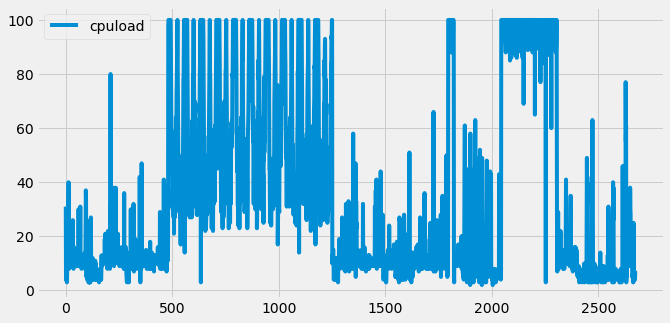

In [170]:
utilData.plot(y='cpuload')

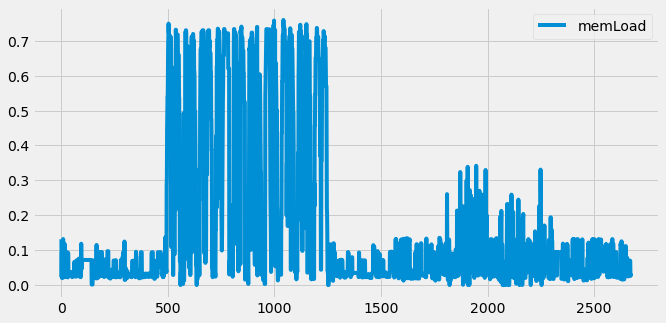

In [174]:
utilData.plot(y='memLoad')

In [176]:
x_axis= utilData.index.values.tolist()

<Figure size 3600x144 with 0 Axes>

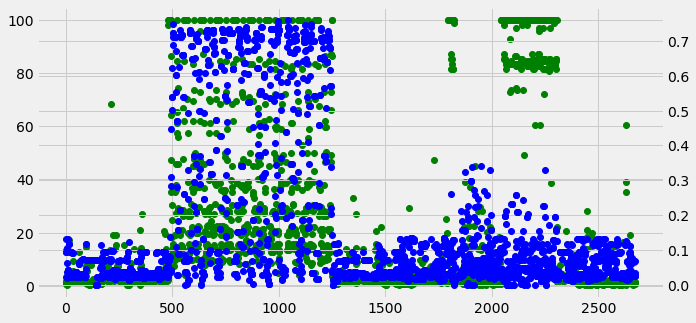

In [195]:
plt.figure(figsize=(50,2))
fig, ax1 = plt.subplots()

x = utilData.index.values.tolist()
y1 = utilData['cpuScore']
y2 = utilData['memLoad']

ax2 = ax1.twinx()

ax1.plot(x, y1, 'go')
ax2.plot(x, y2, 'bo')